<a href="https://colab.research.google.com/github/sreeja-g/wind_speed_forecasting/blob/master/wind_speed_hour_parallelized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os

In [0]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()

In [0]:
try:
  spark.stop()
except:
  pass
  
from pyspark import SparkContext
sc = SparkContext(appName="wind_forecast")
from pyspark.sql import SparkSession
spark=SparkSession(sc)

In [155]:
!pip install ewtpy

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ewtpy

In [157]:
import gzip
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data = pd.read_csv("drive/My Drive/wind_data/data.txt", sep = ', ', header = None, engine='python')

In [0]:
speed_data=pd.DataFrame(data[9].values,columns=['speed'])

In [0]:
speed_data.index=pd.to_datetime(data[0], format='%Y-%m-%d %H:%M')
speed_data.index.name = 'date_time'

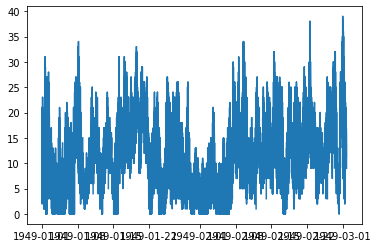

In [161]:
plt.plot(speed_data)

In [162]:
speed_data.head()

,speed
date_time,
1949-01-01,15.0
1949-01-01,2.0
1949-01-01,21.0
1949-01-01,12.0
1949-01-01,21.0


In [163]:
speed_data.isna().sum()

speed    177
dtype: int64

In [164]:
speed_data=speed_data.fillna(speed_data.bfill())
speed_data.isna().sum()

speed    0
dtype: int64

In [165]:
speed_data.head()

,speed
date_time,
1949-01-01,15.0
1949-01-01,2.0
1949-01-01,21.0
1949-01-01,12.0
1949-01-01,21.0


In [0]:
speed_data=speed_data.resample('H').mean()

In [167]:
speed_data.head()

,speed
date_time,
1949-01-01 00:00:00,14.200000
1949-01-01 01:00:00,14.166667
1949-01-01 02:00:00,16.000000
1949-01-01 03:00:00,15.500000
1949-01-01 04:00:00,14.666667


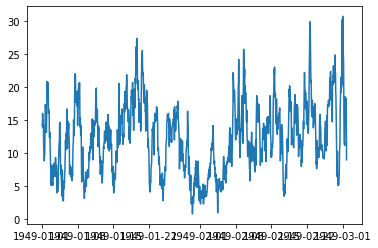

In [168]:
plt.plot(speed_data)

In [0]:
speed_data_grouped = [grp['speed'].values.tolist() for key, grp in speed_data.groupby([speed_data.index.hour])]

###Elm

In [0]:
class Elm:

  def __init__(self,w_0=None,b_0=None,beta=None):
    self.n_value = 10
    self.m_value = 1
    self.l_value = int((2/3)*(self.n_value+self.m_value))

    if w_0 is not None:
      self.weights = np.array(w_0)
      self.bias = np.array(b_0)
      self.beta = np.array(beta)
    else:
      self.weights = 2*np.random.random((self.n_value,self.l_value)) - 1
      self.bias = 2*np.random.random((self.l_value)) - 1
      self.beta = beta
    
    

  def fit(self,X_train,y_train):

    H=self.get_H_matrix(X_train)
    self.beta=np.matmul(np.linalg.pinv(H),y_train)
    return (self.weights,self.bias,self.beta)

  def predict(self,X_test):
    H=self.get_H_matrix(X_test)
    return np.matmul(H,self.beta)


  def get_H_matrix(self,x):
    H = np.empty((0,self.l_value))
    for i in range(len(x)):
      f_x,g_x=0,0
      f_x=np.matmul(x[i],self.weights)+self.bias 
      g_x=self.sigmoid(f_x) 
      H=np.append(H,[g_x],axis=0)
    return H


  def sigmoid(self,value):
    return 1/(1 + np.exp(-value))


In [0]:
def make_lag_data(x_data,n_value,m_value):
  X = []
  y = []
  for i in range(n_value, len(x_data)-m_value+1):
    X.append(x_data[(i-n_value):(i)])
    y.append(x_data[i:i+m_value])
  X=np.array(X)
  X=X.reshape(X.shape[0],X.shape[1])
  y=np.array(y)
  y=y.reshape(y.shape[0],y.shape[1])
  return (X,y)

In [0]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
ewtpy_value=5

X_train_all=[[] for i in range(ewtpy_value)]
y_train_all=[[] for i in range(ewtpy_value)]
X_test_all=[[] for i in range(ewtpy_value)]
y_test_all=[[] for i in range(ewtpy_value)]

for each in speed_data_grouped:

  ewt,  mfb ,boundaries = ewtpy.EWT1D(np.array(each), N = ewtpy_value)
  ewt=ewt.transpose()

  data_all=[]
  for i in range(len(ewt)):
    wavelet=ewt[i]
    wavelet=np.array(wavelet)
    wavelet=np.reshape(wavelet, (-1, 1))
    data_all.append(wavelet)

  for i in range(len(data_all)):
    
    wavelet=data_all[i]

    input_values=10
    output_values=1

    (X,y)=make_lag_data(wavelet,input_values,output_values)


    X_train = X[:int(len(X)*0.78)]
    y_train = y[:int(len(y)*0.78)]

    X_test = X[int(len(X)*0.78):]
    y_test = y[int(len(y)*0.78):]

    X_train_all[i].append(X_train)
    y_train_all[i].append(y_train)
    X_test_all[i].append(X_test)
    y_test_all[i].append(y_test)
    


In [0]:
def train_model(X_train_,y_train_):
  elm_=Elm()
  return elm_.fit(X_train_,y_train_)

In [0]:
learnt_elms=[]
for i in range(ewtpy_value):

  learning_step=sc.parallelize(X_train_all[i]).zipWithIndex().map(lambda x: train_model(X_train_all[i][x[1]],y_train_all[i][x[1]])).collect()

  learnt_elms.append(learning_step)


In [0]:
y_test_collected=[[] for i in range(len(X_test_all[0]))]
y_pred_collected=[[] for i in range(len(X_test_all[0]))]

for i in range(ewtpy_value): 

  for j in range(len(X_test_all[i])):

    y_test_collected[j].append(y_test_all[i][j])
    new_elm=Elm(learnt_elms[i][j][0],learnt_elms[i][j][1],learnt_elms[i][j][2])
    y_pred_collected[j].append(new_elm.predict(X_test_all[i][j]))


test data
mse:  39.6830746457785
mae:  5.271009226515154
mape:  36.0104831466904


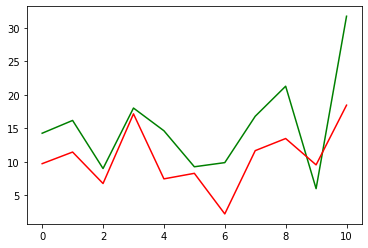

test data
mse:  21.754463457337874
mae:  3.094382458487944
mape:  20.503122373787477


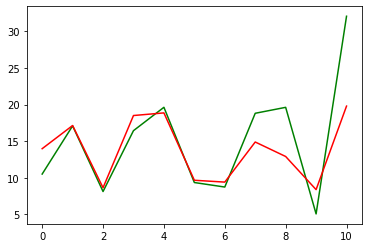

test data
mse:  18.933402790311344
mae:  3.525821075308687
mape:  25.166875225215605


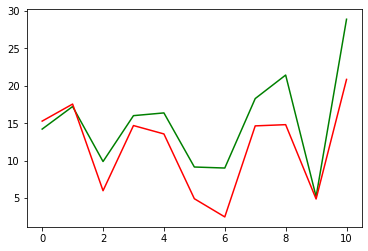

test data
mse:  5.573302714714415
mae:  1.65766440418345
mape:  13.014181156256155


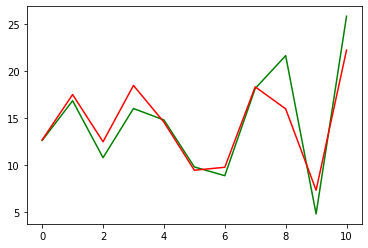

test data
mse:  12.775960732204005
mae:  2.451772155640854
mape:  14.543983931596035


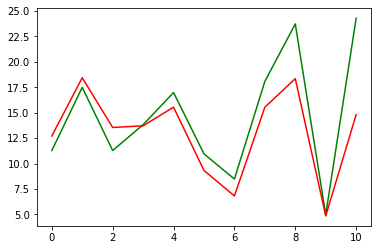

test data
mse:  12.097772992677333
mae:  2.675782599400017
mape:  19.22724092785847


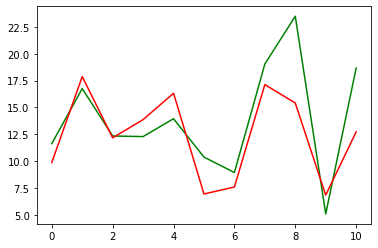

test data
mse:  4.6020631072002915
mae:  1.6043932459450956
mape:  12.67620207580045


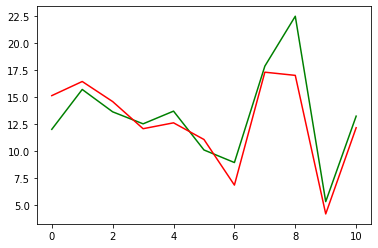

test data
mse:  10.023846395552379
mae:  2.394756164955824
mape:  19.588957372884135


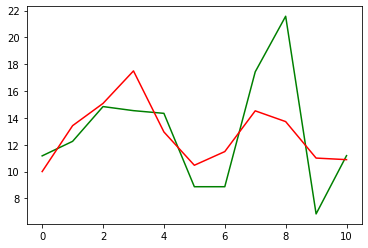

test data
mse:  7.934413569634052
mae:  2.325960553040653
mape:  18.527180901240143


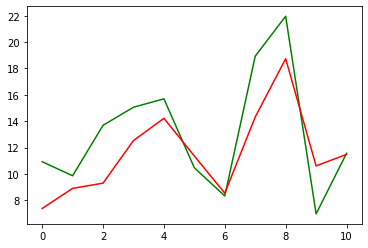

test data
mse:  8.129339894641138
mae:  2.0974344547797927
mape:  15.053671737331243


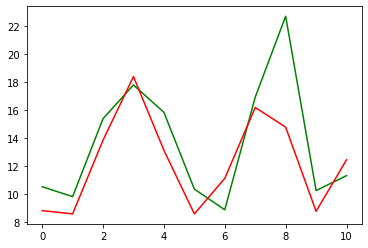

test data
mse:  10.377029797422416
mae:  2.757843278955861
mape:  18.50674639384449


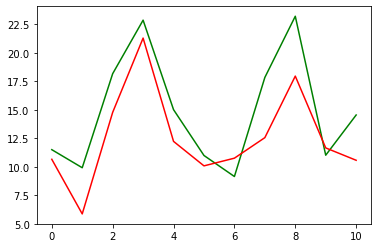

test data
mse:  25.785393978139613
mae:  4.1638067048941645
mape:  22.003570230249643


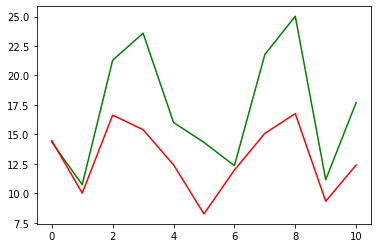

test data
mse:  61.526675044797166
mae:  7.13929150161363
mape:  37.69642300377207


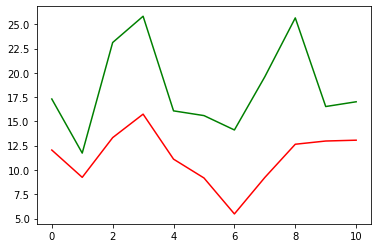

test data
mse:  17.80101762383988
mae:  3.5734537890397196
mape:  18.571808492170515


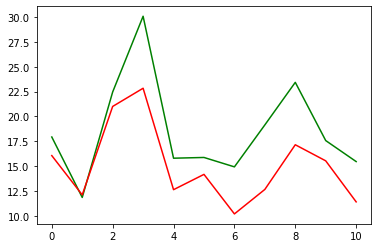

test data
mse:  30.465498006869396
mae:  4.449167277615035
mape:  24.06138187548268


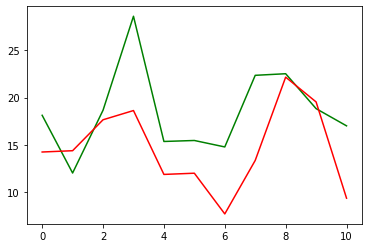

test data
mse:  7.4893720372111146
mae:  2.47202909665719
mape:  13.412888437180733


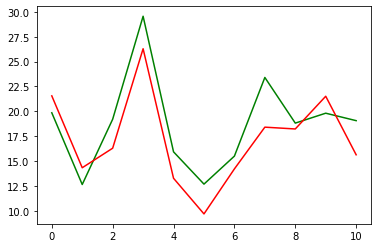

test data
mse:  12.42921958515409
mae:  2.9108127504149492
mape:  15.878604464524468


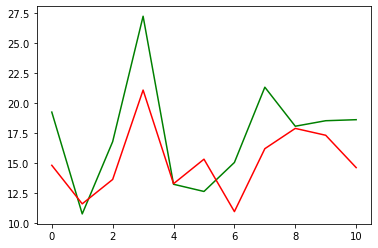

test data
mse:  20.161643667421362
mae:  3.6899900587942214
mape:  20.305740303596416


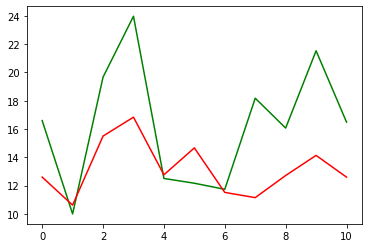

test data
mse:  11.179787800667892
mae:  2.8015711811469646
mape:  20.606623421478584


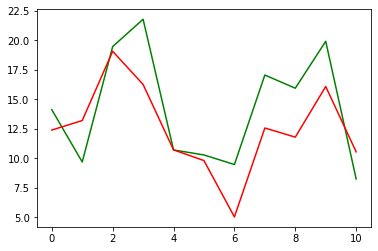

test data
mse:  12.071596397194963
mae:  2.8758487640741306
mape:  19.128584665174277


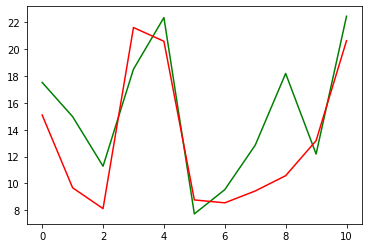

test data
mse:  16.877552669509207
mae:  3.4796902246522863
mape:  23.643231220329966


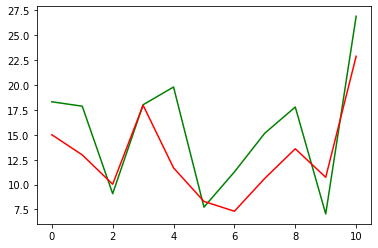

test data
mse:  12.655632841492356
mae:  2.508054444010352
mape:  16.40318268392583


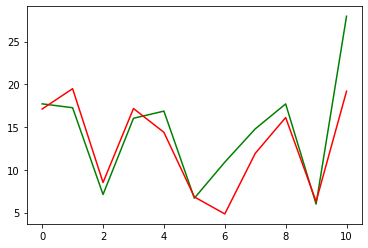

test data
mse:  14.516284212404718
mae:  2.5711160123366716
mape:  19.99358641583015


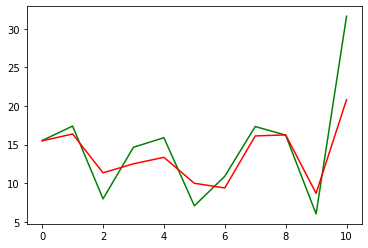

test data
mse:  10.839597623334898
mae:  2.801591868263964
mape:  22.45926513232779


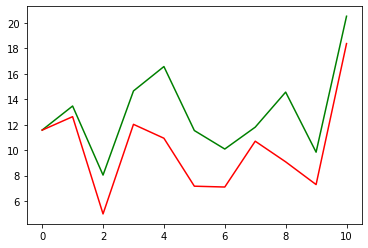

In [177]:
for i in range(len(y_test_collected)):

  y_test_all=np.sum(y_test_collected[i],axis=0)
  y_pred_all=np.sum(y_pred_collected[i],axis=0)

  print("test data")
  print("mse: ",mean_squared_error(y_test_all,y_pred_all))
  print("mae: ",mean_absolute_error(y_test_all,y_pred_all))
  print("mape: ",mean_absolute_percentage_error(y_test_all,y_pred_all))

  plt.plot(y_test_all,color='green')
  plt.plot(y_pred_all,color='red')
  plt.show()